In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import pandas_datareader.data as web
import datetime as dt
from scipy.stats import norm
from scipy.optimize import minimize_scalar 
from scipy.optimize import minimize
from scipy.integrate import quad
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import warnings 

In [2]:
%matplotlib ipympl

# First version

https://www.codearmo.com/python-tutorial/heston-model-simulation-python

In [3]:
N = norm.cdf

In [4]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

In [5]:
def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    

In [6]:
def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        

### Generating Correlated Random Normal Variables

In [7]:
rho = -0.7
Ndraws = 1000
mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

In [8]:
W = np.random.multivariate_normal(mu, cov, size=Ndraws)

Text(0.5, 1.0, 'Correlated Random Variables')

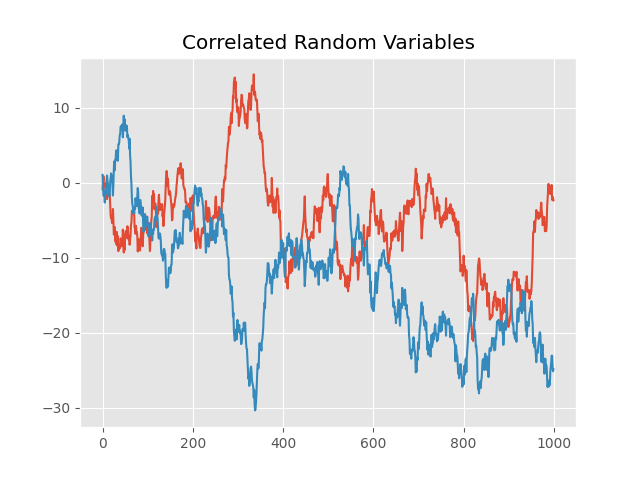

In [9]:
plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [10]:
print(np.corrcoef(W.T))

[[ 1.         -0.73008322]
 [-0.73008322  1.        ]]


### Simulating a Heston Process

In [11]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

In [12]:
kappa =4
theta = 0.02
v_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =50000
steps = 20000   # Changed from 2000 to 20000 for better results
T = 1

In [13]:
prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  

prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]       

gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T , 
                                np.sqrt(theta)*np.sqrt(T), size=paths))


Text(0, 0.5, 'Density')

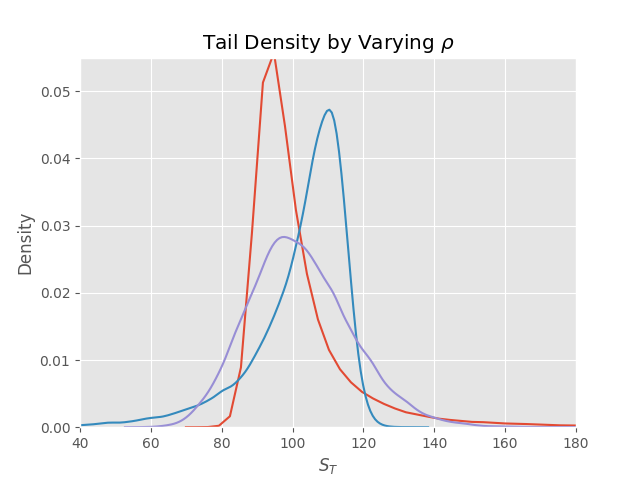

In [14]:
fig, ax = plt.subplots()

ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$ ", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')

### Pricing Options with Heston Model

In [15]:
strikes =np.arange(30, 200,1)

puts = [] 

for K in strikes:
    P = np.mean(np.maximum(K-prices_neg,0))*np.exp(-r*T)
    puts.append(P)


ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]


In [16]:
plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()

# Second version

https://blog.quantinsti.com/heston-model/

### Python implementation to visualise stock price dynamics and volatility dynamics

In [17]:
# Parameters of both equations
T = 1.0 # Total time
N = 1000 # Number of time steps
dt = T / N # Time step size
t = np.linspace(0.0, T, N+1) # Time vector
mu = 0.1 # Expected return
v0 = 0.1 # Initial volatility
kappa = 3.0 # Mean reversion rate
theta = 0.2 # Long-term average volatility
sigma = 0.1 # Volatility

In [18]:
# Generate random shocks - random fluctuations
dW1 = np.random.randn(N) * np.sqrt(dt)
dW2 = np.random.randn(N) * np.sqrt(dt)

In [19]:
# Initialize arrays for stock price and volatility
S = np.zeros(N+1)
v = np.zeros(N+1)
S[0] = 100.0 # Initial stock price
v[0] = v0 # Initial volatility

In [20]:
# Euler-Maruyama method to solve the stochastic differential equation for stock price dynamics
for i in range(1, N+1):
    v[i] = v[i-1] + kappa * (theta - v[i-1]) * dt + sigma * np.sqrt(v[i-1]) * dW2[i-1]
    S[i] = S[i-1] * (1 + mu * dt + np.sqrt(v[i-1]) * dW1[i-1])

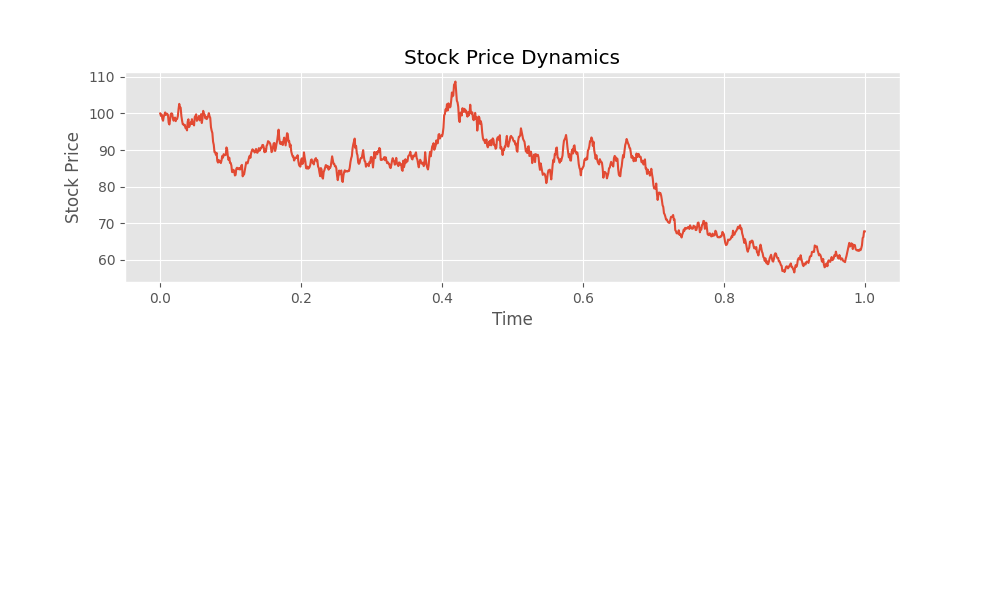

In [21]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, S)
plt.title('Stock Price Dynamics')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)

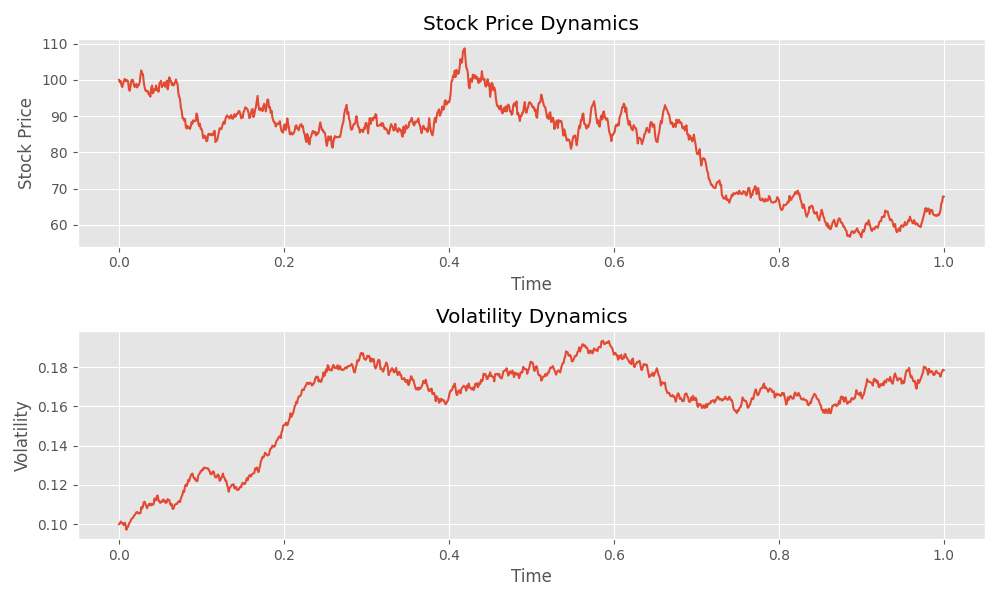

In [22]:
plt.subplot(2, 1, 2)
plt.plot(t, v)
plt.title('Volatility Dynamics')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

### Steps for pricing European options using Heston model

# Check very carefully, why does call price decrease when initial stock price increase? How can option prices be negative?

https://quant.stackexchange.com/questions/18684/heston-model-option-price-formula#:~:text=The%20Heston%20model%20is%20given,Wt%3Dρdt.

In [23]:
# Model parameters
S0 = 100.0    # Initial stock price
K = 100.0     # Strike price
r = 0.05      # Risk-free rate
T = 1.0       # Time to maturity
kappa = 2.0   # Mean reversion rate
theta = 0.05  # Long-term average volatility
sigma = 0.3   # Volatility of volatility
rho = -0.5    # Correlation coefficient
v0 = 0.05     # Initial volatility

In [24]:
# Define characteristic functions
def heston_characteristic_function(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
   xi = kappa - rho * sigma * 1j * u
   d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
   g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
   C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
   D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
   return np.exp(C + D * v0 + 1j * u * np.log(S0))

In [25]:
# Define functions to compute call and put options prices
def heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral

In [26]:
def heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) / np.pi * integral - S0 + K * np.exp(-r * T)

In [27]:
# Calculate call and put option prices
call_price = heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0)
put_price = heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0)

In [28]:
print("European Call Option Price:", np.round(call_price, 2))
print("European Put Option Price:", np.round(put_price, 2))

European Call Option Price: 27.63
European Put Option Price: 15.06


### Creating charts

In [29]:
# Model parameters
S0 = 100.0    # Initial stock price
K = 100.0     # Strike price
r = 0.05      # Risk-free rate
T = 1.0       # Time to maturity
kappa = 2.0   # Mean reversion rate
theta = 0.05  # Long-term average volatility
sigma = 0.3   # Volatility of volatility
rho = -0.5    # Correlation coefficient
v0 = 0.05     # Initial volatility

In [30]:
# Define functions to compute call and put options prices
def heston_call_price_chart(K, r, T, kappa, theta, sigma, rho, v0):
    def heston_characteristic_function(u):
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        return np.exp(C + D * v0 + 1j * u * np.log(S0))
    
    integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j))
    integral, _ = quad(integrand, 0, np.inf)
    return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral

In [31]:
def heston_put_price_chart(K, r, T, kappa, theta, sigma, rho, v0):
    def heston_characteristic_function(u):
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        return np.exp(C + D * v0 + 1j * u * np.log(S0))
    
    integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j))
    integral, _ = quad(integrand, 0, np.inf)
    return np.exp(-r * T) / np.pi * integral - S0 + K * np.exp(-r * T)

In [32]:
def HestonPricing(model):

    axis_color = 'skyblue'

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Adjust the subplots region to leave some space for the sliders and buttons
    fig.subplots_adjust(left=0.30, bottom=0.40)

    # Draw the initial plot
    # The 'line' variable is used for modifying the line later
    [line] = ax.plot(S0, model(K, r, T, kappa, theta, sigma, rho, v0), linewidth=2, color='red')
    ax.set_xlim([0, 200])                               #x-axis limits to be adjusted as needed
    ax.set_ylim([-10, 100])                              #y-axis limits to be adjusted as needed
    ax.set_xlabel('Underlying Price')
    ax.set_ylabel('Option price')
    ax.set_title(f"{model.__name__} Option Price")

    # Add eight sliders for tweaking the parameters

    # Define an axes area and draw a slider in it

    rf_slider_ax  = fig.add_axes([0.25, 0.30, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.10, valinit=r)            #range for risk-free to be adjusted as needed

    # Draw another slider
    time_slider_ax = fig.add_axes([0.25, 0.27, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T)                #range for time to be adjusted as needed

    # Draw another slider
    strike_slider_ax  = fig.add_axes([0.25, 0.24, 0.65, 0.03], facecolor=axis_color)
    strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=K)          #range for strike to be adjusted as needed

    # Draw another slider
    kappa_slider_ax = fig.add_axes([0.25, 0.21, 0.65, 0.03], facecolor=axis_color)
    kappa_slider = Slider(kappa_slider_ax, 'Kappa', 0.1, 5.0, valinit=kappa)         #range for kappa to be adjusted as needed

    # Draw another slider
    theta_slider_ax = fig.add_axes([0.25, 0.18, 0.65, 0.03], facecolor=axis_color)
    theta_slider = Slider(theta_slider_ax, 'Theta', 0.01, 0.9, valinit=theta)         #range for theta to be adjusted as needed

    # Draw another slider
    sigma_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
    sigma_slider = Slider(sigma_slider_ax, 'Sigma', 0.0, 0.9, valinit=sigma)         #range for sigma to be adjusted as needed

    # Draw another slider
    rho_slider_ax = fig.add_axes([0.25, 0.12, 0.65, 0.03], facecolor=axis_color)
    rho_slider = Slider(rho_slider_ax, 'Rho', -0.9, 0.9, valinit=rho)                 #range for rho to be adjusted as needed

    # Draw another slider
    v0_slider_ax = fig.add_axes([0.25, 0.09, 0.65, 0.03], facecolor=axis_color)
    v0_slider = Slider(v0_slider_ax, 'v0', 0.01, 0.9, valinit=v0)                      #range for v0 to be adjusted as needed

    # Define an action for modifying the line when any slider's value changes
    def sliders_on_changed(val):
        line.set_ydata(model(K=strike_slider.val, sigma=sigma_slider.val, r=rf_slider.val, T=time_slider.val, kappa=kappa_slider.val, theta=theta_slider.val, rho=rho_slider.val, v0=v0_slider.val))
        fig.canvas.draw_idle()
    rf_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)
    strike_slider.on_changed(sliders_on_changed)
    sigma_slider.on_changed(sliders_on_changed)
    kappa_slider.on_changed(sliders_on_changed)
    theta_slider.on_changed(sliders_on_changed)
    rho_slider.on_changed(sliders_on_changed)
    v0_slider.on_changed(sliders_on_changed)

    # Add a button for resetting the parameters
    reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        rf_slider.reset()
        time_slider.reset()
        strike_slider.reset()
        sigma_slider.reset()
        kappa_slider.reset()
        theta_slider.reset()
        rho_slider.reset()
        v0_slider.reset()
    reset_button.on_clicked(reset_button_on_clicked)

    # Add a set of radio buttons for changing color
    color_radios_ax = fig.add_axes([0.025, 0.5, 0.15, 0.15], facecolor=axis_color)
    color_radios = RadioButtons(color_radios_ax, ('red', 'blue', 'green'), active=0)
    def color_radios_on_clicked(label):
        line.set_color(label)
        fig.canvas.draw_idle()
    color_radios.on_clicked(color_radios_on_clicked)

    plt.show()

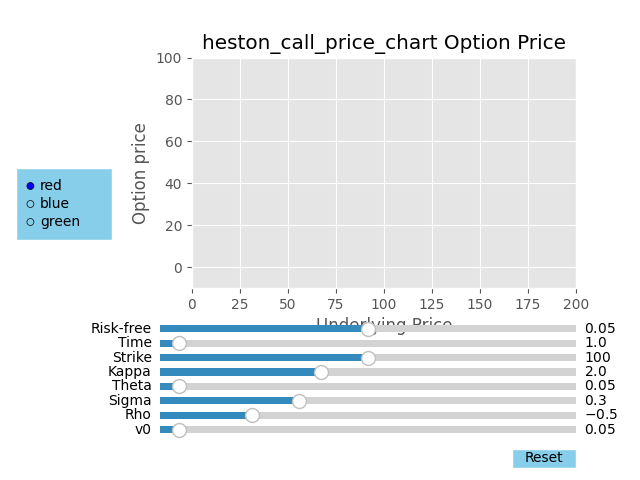

In [33]:
HestonPricing(heston_call_price_chart)

### Tried again with ChatGPT code

In [34]:
def heston_call_price_chart(S0, K, r, T, kappa, theta, sigma, rho, v0):
    def heston_characteristic_function(u):
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        return np.exp(C + D * v0 + 1j * u * np.log(S0))
    
    integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j))
    integral, _ = quad(integrand, 0, np.inf)
    return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral

In [35]:
def HestonPricing(model):

    axis_color = 'skyblue'

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Adjust the subplots region to leave some space for the sliders and buttons
    fig.subplots_adjust(left=0.30, bottom=0.40)

    S0_values = np.linspace(50, 150, 100)  # Range of underlying prices for x-axis
    prices = [model(S, K, r, T, kappa, theta, sigma, rho, v0) for S in S0_values]

    [line] = ax.plot(S0_values, prices, linewidth=2, color='red')
    ax.set_xlim([50, 150])
    ax.set_ylim([-10, 100])
    ax.set_xlabel('Underlying Price')
    ax.set_ylabel('Option price')
    ax.set_title(f"{model.__name__} Option Price")

    # Define axes for sliders
    rf_slider_ax  = fig.add_axes([0.25, 0.30, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.10, valinit=r)

    time_slider_ax = fig.add_axes([0.25, 0.27, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T)

    strike_slider_ax  = fig.add_axes([0.25, 0.24, 0.65, 0.03], facecolor=axis_color)
    strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=K)

    kappa_slider_ax = fig.add_axes([0.25, 0.21, 0.65, 0.03], facecolor=axis_color)
    kappa_slider = Slider(kappa_slider_ax, 'Kappa', 0.1, 5.0, valinit=kappa)

    theta_slider_ax = fig.add_axes([0.25, 0.18, 0.65, 0.03], facecolor=axis_color)
    theta_slider = Slider(theta_slider_ax, 'Theta', 0.01, 0.9, valinit=theta)

    sigma_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
    sigma_slider = Slider(sigma_slider_ax, 'Sigma', 0.0, 0.9, valinit=sigma)

    rho_slider_ax = fig.add_axes([0.25, 0.12, 0.65, 0.03], facecolor=axis_color)
    rho_slider = Slider(rho_slider_ax, 'Rho', -0.9, 0.9, valinit=rho)

    v0_slider_ax = fig.add_axes([0.25, 0.09, 0.65, 0.03], facecolor=axis_color)
    v0_slider = Slider(v0_slider_ax, 'v0', 0.01, 0.9, valinit=v0)

    def sliders_on_changed(val):
        prices = [model(S, strike_slider.val, rf_slider.val, time_slider.val, kappa_slider.val, theta_slider.val, sigma_slider.val, rho_slider.val, v0_slider.val) for S in S0_values]
        line.set_ydata(prices)
        fig.canvas.draw_idle()

    rf_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)
    strike_slider.on_changed(sliders_on_changed)
    sigma_slider.on_changed(sliders_on_changed)
    kappa_slider.on_changed(sliders_on_changed)
    theta_slider.on_changed(sliders_on_changed)
    rho_slider.on_changed(sliders_on_changed)
    v0_slider.on_changed(sliders_on_changed)
    
    # Add a button for resetting the parameters
    reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        rf_slider.reset()
        time_slider.reset()
        strike_slider.reset()
        sigma_slider.reset()
        kappa_slider.reset()
        theta_slider.reset()
        rho_slider.reset()
        v0_slider.reset()
    reset_button.on_clicked(reset_button_on_clicked)

    plt.show()

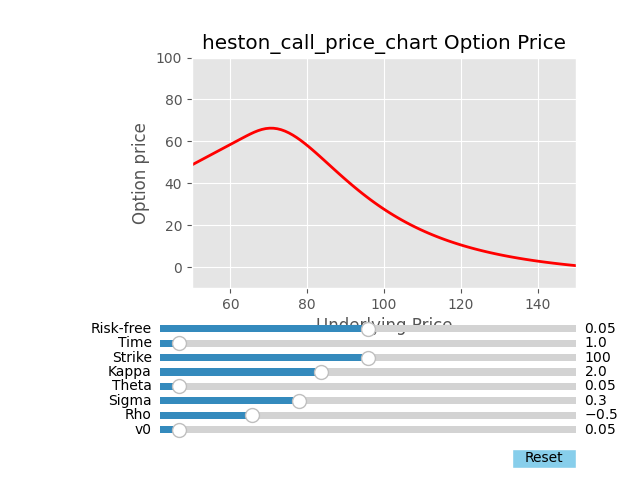

In [36]:
HestonPricing(heston_call_price_chart)

In [37]:
S0_values = np.linspace(50, 150, 100)  # Range of underlying prices for x-axis
prices = [heston_call_price_chart(S, K, r, T, kappa, theta, sigma, rho, v0) for S in S0_values]

In [38]:
prices

[48.78073561245556,
 49.76620501884808,
 50.751674425209615,
 51.73714383153559,
 52.722613237816,
 53.7080826440918,
 54.693552050396846,
 55.67902145671229,
 56.66449086302664,
 57.64996026934572,
 58.63542967117178,
 59.6208937955262,
 60.606096594468,
 61.58844271914196,
 62.557563118239656,
 63.490384275060805,
 64.35174183051792,
 65.10019051438447,
 65.69533315187932,
 66.10366907560179,
 66.30184339450112,
 66.27750037314786,
 66.02847085295957,
 65.56105275880506,
 64.88796850607184,
 64.02637291648384,
 62.99611118940754,
 61.81830558800203,
 60.51427597895001,
 59.104760841425914,
 57.609389204466076,
 56.0463514159898,
 54.43222097568312,
 52.781886630296,
 51.10856214608907,
 49.423848068017534,
 47.737826489817856,
 46.05917456292167,
 44.39528689404188,
 42.752399694032356,
 41.135712157110085,
 39.5495019823823,
 37.99723335185211,
 36.48165638485197,
 35.00489782199153,
 33.56854292499877,
 32.1737090265329,
 30.82111108844332,
 29.511119989691892,
 28.243813986301042,